In [127]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("*********   Loaded library     ***********")

*********   Loaded library     ***********


In [128]:
CLIENT_ID = 'ZUHO10L1UTMAV5BI1WSZ2FT5QS1HBJGDV5BLL2FEQOAEXNOM' # your Foursquare ID
CLIENT_SECRET = 'FUBCP2OB2RTZT0JEQL5QKZHAUCFLVV5FEQWPGB4UTD34YFYU' # your Foursquare Secret
VERSION = '20200204'
LIMIT = 150

address = "Tirupati"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   
longitude =location.longitude 

interested_location='Interested location : {},{}'.format(latitude,longitude)
print(interested_location)

Interested location : 13.6316368,79.4231711


In [129]:
radius = 2500
LIMIT = 100

venues = [] 
search_query = 'hotel'
search_query_res = 'restaurant'   

url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)
results_hotel = requests.get(url_hotel).json()
results_restaurant = requests.get(url_restaurant).json()

In [130]:
venues_hotel = results_hotel['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_hotel,dataframe_restaurant], sort=False)

print("There are {} restaurants and hotels at".format(dataframe.shape[0]), address)



There are 65 restaurants and hotels at Tirupati


In [131]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
hotels_df.head()

,name,categories,distance,lat,lng,id
0,Mayura Hotel,Indian Restaurant,417,13.628631,79.425481,4d301808a241f04d2b06b127
1,Fortune Kences Hotel,Hotel,519,13.628853,79.427027,4bd7c31b304fce72b9fe33ab
2,Hotel Sindhuri Park,Hotel,350,13.629811,79.420533,4f1d2f7ae4b0e2eeed178ad3
3,Hotel Amaravati,Hotel,241,13.629508,79.423599,54fb96b7498e7f86ee2669f0
4,Hotel Saravana Bhavan,Indian Restaurant,500,13.630565,79.427667,506552f9e4b08bbff80dfa78


In [132]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Address

# add a red circle marker to represent the core location of Address
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        location=[lat, lng],
        radius=4,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)
# display map
hotels_map

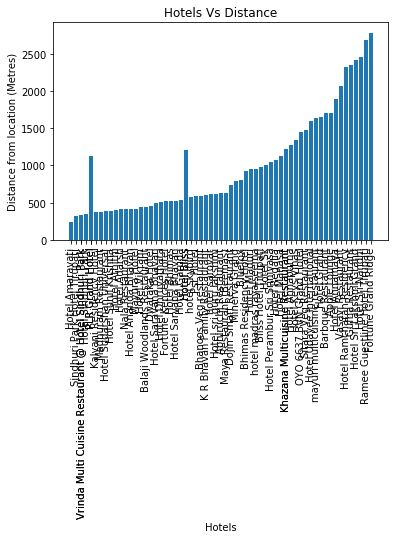

Average distance between hotels and core location is 975 metres


In [133]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.bar(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between hotels and core location is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))

In [134]:
radius=2500
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [135]:
import requests

results_venues = requests.get(url_venues).json()
print("There are {} venues around".format(len(results_venues['response']['groups'][0]['items'])), address)

There are 17 venues around Tirupati


In [136]:
items_venues = results_venues['response']['groups'][0]['items']
dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

0                     Minerva Grand
1                      Mayura Hotel
2                       Hotel Bliss
3            Bhimas Residency Hotel
4                     Dwaraka Hotel
5                     Bhimas Deluxe
6                     Hotel Regalia
7          Tirupati Railway Station
8     Udayee International Tirupati
9                       Big Cinemas
10                              CCD
11             Fortune Kences Hotel
12                     Idli Factory
13                  Sharvana Bhavan
14                    Reliance Mart
15                  kapilatheertham
16                Raj Park Tirupati
Name: name, dtype: object

In [137]:
search_query_list = ['temple','church','park','museum', 'masjid'] 
radius =1000
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng','id']])
search_df

,name,categories,distance,lat,lng,id
0,Govindraja Swamy Temple,Temple,387,13.629792,79.420137,4e0de0a0aeb7a5b33ee3d055
1,Sri Parasurameshwara Temple,Shrine,298,13.628961,79.423363,54fed272498e8e46726210d7
2,Tataigunta Gangamma temple,Hindu Temple,275,13.634087,79.423512,544b3233498e50c1dd354d89
3,Tallapaka Pedda Gangamma Temple,Temple,360,13.628654,79.424461,521f83c511d2b89b6bb18c38
4,jain temple Tirupati,Building,419,13.630958,79.419357,5341f40a498e9a7be7a78cfd
5,Padmavathi Temple Tiruchanur,Temple,420,13.629692,79.426501,4e9d72f9b6348df6f7213821
6,"Sri Rama Temple, Tirupati",Temple,649,13.628080,79.427930,4f7714a4e4b0b009ede8dc66
7,kodandarama Swamy temple,Hindu Temple,802,13.634886,79.416550,534c9f9f498edb8189e31385
0,Hotel Sindhuri Park,Hotel,350,13.629811,79.420533,4f1d2f7ae4b0e2eeed178ad3
1,Vrinda Multi Cuisine Restaurant @ Hotel Sindhu...,Indian Restaurant,332,13.630182,79.420483,4fa38a2ce4b0d905243b868e


In [138]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)



In [139]:
to_drop = ['Hotel', 'Restautant','hotel','Resort']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in".format(df_venues.shape[0]), address)
df_venues[['name','distance','id']]

There are 19 venues in Tirupati


,name,distance,id
0,Minerva Grand,792,5079323ee4b0dad8221076c2
1,Bhimas Deluxe,463,4f2e7cd5e4b04297f85689c8
2,Tirupati Railway Station,487,4fb666aae4b094ed55c92e84
3,Udayee International Tirupati,588,4fe6e726e4b0bdc4f4bb9fbb
4,Big Cinemas,566,4ce790808ef78cfa385d949b
5,CCD,1806,52132e32498e79954054ecdb
6,Idli Factory,472,516a16ebe4b074738a191da7
7,Sharvana Bhavan,502,51aa300b498ee7f30aebea3f
8,Reliance Mart,843,4e30f772628430b0810968e5
9,kapilatheertham,2018,4f5960e8e4b04b8b5c5e4ce5


In [140]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the interested location
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Other Venues as black circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map


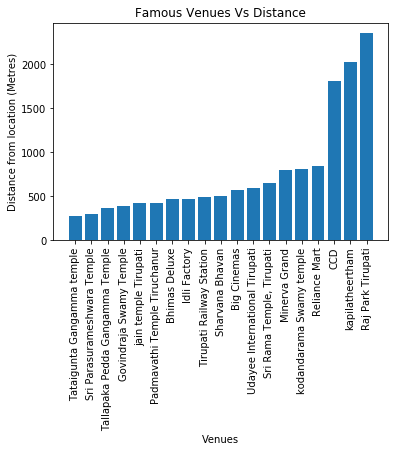

In [113]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()

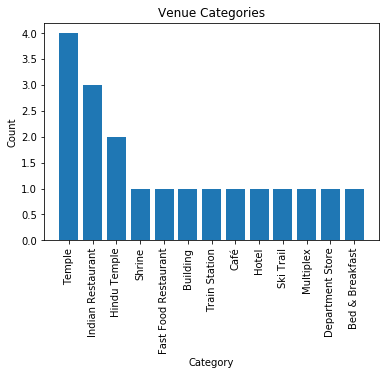

In [141]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()

In [142]:
#Rating of venues
rating_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

In [143]:
rate_dict = {'Venue': df_venues.name, 'Rating': rating_df,'distance':df_venues.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
0,Minerva Grand,7.6,792
1,Bhimas Deluxe,6.3,463
2,Tirupati Railway Station,6,487
3,Udayee International Tirupati,6,588
4,Big Cinemas,5.8,566
5,CCD,6.2,1806
6,Idli Factory,No Rating Yet,472
7,Sharvana Bhavan,No Rating Yet,502
8,Reliance Mart,5.6,843
9,kapilatheertham,No Rating Yet,2018


In [144]:


tips_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    print(result)
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
    tips=result['response']['venue']['tips']['count']
    tips_df.append(tips)



', 'categories': [{'id': '4eb1c0f63b7b52c0e1adc2eb', 'name': 'Ski Trail', 'pluralName': 'Ski Trails', 'shortName': 'Trail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/ski_trail_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'beenHere': {'count': 0, 'unconfirmedCount': 0, 'marked': False, 'lastCheckinExpiredAt': 0}, 'specials': {'count': 0, 'items': []}, 'photos': {'count': 0, 'groups': []}, 'reasons': {'count': 0, 'items': []}, 'hereNow': {'count': 0, 'summary': 'Nobody here', 'groups': []}, 'createdAt': 1331257576, 'tips': {'count': 0, 'groups': [{'type': 'others', 'name': 'All tips', 'count': 0, 'items': []}]}, 'shortUrl': 'http://4sq.com/yuJrzj', 'timeZone': 'Asia/Kolkata', 'listed': {'count': 0, 'groups': [{'type': 'others', 'name': 'Lists from other people', 'count': 0, 'items': []}]}, 'pageUpdates': {'count': 0, 'items': []}, 'inbox': {'count':

In [145]:


tips_dict = {'Venue': df_venues.name, 'Tips': tips_df,'distance':df_venues.distance}
tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('Tips',ascending = False)
tips



,Venue,Tips,distance
2,Tirupati Railway Station,13,487
1,Bhimas Deluxe,9,463
0,Minerva Grand,8,792
8,Reliance Mart,7,843
3,Udayee International Tirupati,6,588
4,Big Cinemas,4,566
5,CCD,4,1806
7,Sharvana Bhavan,4,502
16,Padmavathi Temple Tiruchanur,3,420
13,Tataigunta Gangamma temple,0,275


In [146]:
rate_df['Tips']=tips['Tips']

#Lets take values of only rated venues
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

only_rated_tips.reset_index(inplace = True,drop = True) 
only_rated_tips

,Venue,Rating,distance,Tips
0,Minerva Grand,7.6,792,8
1,Bhimas Deluxe,6.3,463,9
2,Tirupati Railway Station,6,487,13
3,Udayee International Tirupati,6,588,6
4,Big Cinemas,5.8,566,4
5,CCD,6.2,1806,4
6,Sharvana Bhavan,No Rating Yet,502,4
7,Reliance Mart,5.6,843,7
8,Padmavathi Temple Tiruchanur,No Rating Yet,420,3


In [147]:


rated_list=[]
for i in range(len(only_rated_tips)):
    rated_tip_temp=only_rated_tips['Venue'][i]
    rated_list.append(rated_tip_temp)

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues



,index,categories,distance,id,lat,lng,name
0,0,Indian Restaurant,792,5079323ee4b0dad8221076c2,13.627407,79.429059,Minerva Grand
1,5,Bed & Breakfast,463,4f2e7cd5e4b04297f85689c8,13.629464,79.419517,Bhimas Deluxe
2,7,Train Station,487,4fb666aae4b094ed55c92e84,13.628278,79.420286,Tirupati Railway Station
3,8,Indian Restaurant,588,4fe6e726e4b0bdc4f4bb9fbb,13.628926,79.427842,Udayee International Tirupati
4,9,Multiplex,566,4ce790808ef78cfa385d949b,13.626645,79.424203,Big Cinemas
5,10,Café,1806,52132e32498e79954054ecdb,13.647768,79.424996,CCD
6,13,Indian Restaurant,502,51aa300b498ee7f30aebea3f,13.630601,79.427694,Sharvana Bhavan
7,14,Department Store,843,4e30f772628430b0810968e5,13.627295,79.429557,Reliance Mart
8,5,Temple,420,4e9d72f9b6348df6f7213821,13.629692,79.426501,Padmavathi Temple Tiruchanur


In [148]:
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,Bed & Breakfast,Café,Department Store,Indian Restaurant,Multiplex,Temple,Train Station
0,Minerva Grand,0,0,0,1,0,0,0
1,Bhimas Deluxe,1,0,0,0,0,0,0
2,Tirupati Railway Station,0,0,0,0,0,0,1
3,Udayee International Tirupati,0,0,0,1,0,0,0
4,Big Cinemas,0,0,0,0,1,0,0


In [149]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [150]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [151]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = final_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [157]:
fin=neighbor_merged.groupby(['Clustersss']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new hotel:{},{}".format(final_latitude,final_longitude))
final_center = [final_latitude, final_longitude]
my_location = geolocator.reverse(final_center)
print("Location Name is ", my_location.raw['display_name'])


Final location (Green Dot in our below given map) of our brand new hotel:13.630111219550525,79.4262345628025
Location Name is  Tirupati Central Bus Station, Jayasam Road, Tirupati, Tirupati (Urban), Chittoor, Andhra Pradesh, 517500, India


In [163]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

In [159]:
my_hotel_vs_all = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Address


# add a red circle marker to represent the my hotel location
folium.features.CircleMarker(
    location = [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)


# add a red circle marker to represent the core location of Address
folium.features.CircleMarker(
    location =[latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        location = [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_hotel_vs_all)
    
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(my_hotel_vs_all)




# display map
my_hotel_vs_all